# Time Series Sales Forecasting with ARIMA

In [73]:
import os
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Wrangling

In [9]:
train=pd.read_csv("../Dataset/train.csv", parse_dates =['date'])
train.shape

(3000888, 6)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [11]:
# check for duplicates

train.duplicated().any()

False

In [12]:
# check for missing values

train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### Missing Dates

In [13]:
# Min and max dates (range of dates)
data_train_start = train.date.min()
data_train_end = train.date.max()

# Generate a date range from start_date to end_date
date_range = pd.date_range(start=data_train_start,end=data_train_end)

# Use the difference between the date_range and the unique dates in the sales data to find missing dates
missing_dates = date_range.difference(train['date'])

print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [14]:
store_nbr = train['store_nbr'].unique()

print(f'Unique stores in the train data are {store_nbr.size}')
store_nbr

Unique stores in the train data are 54


array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [15]:
families = train['family'].unique()

print(f'Unique families in the train data are {families.size}')
families

Unique families in the train data are 33


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [16]:
missing_data_points = product(missing_dates, store_nbr, families)

new_data = pd.DataFrame(data=missing_data_points, columns=['date', 'store_nbr', 'family'])
new_data.head(10)

,date,store_nbr,family
0,2013-12-25,1,AUTOMOTIVE
1,2013-12-25,1,BABY CARE
2,2013-12-25,1,BEAUTY
3,2013-12-25,1,BEVERAGES
4,2013-12-25,1,BOOKS
5,2013-12-25,1,BREAD/BAKERY
6,2013-12-25,1,CELEBRATION
7,2013-12-25,1,CLEANING
8,2013-12-25,1,DAIRY
9,2013-12-25,1,DELI


In [17]:
train = pd.concat([train, new_data],axis=0)
train.set_index('date', inplace=True)
train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0.0,1,AUTOMOTIVE,0.0,0.0
2013-01-01,1.0,1,BABY CARE,0.0,0.0
2013-01-01,2.0,1,BEAUTY,0.0,0.0
2013-01-01,3.0,1,BEVERAGES,0.0,0.0
2013-01-01,4.0,1,BOOKS,0.0,0.0


In [18]:
# drop 'id' column
train.drop(columns=['id'], inplace=True)

In [20]:
missing_dates = set(date_range) - set(train.index.unique())

print("Missing dates:", missing_dates)

Missing dates: set()


In [19]:
train.isna().sum()

store_nbr         0
family            0
sales          7128
onpromotion    7128
dtype: int64

In [21]:
train['sales'] = train['sales'].fillna(0)
train['onpromotion'] = train['onpromotion'].fillna(0)

In [22]:
train.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [23]:
train.sort_index(inplace=True)
train.tail()

,store_nbr,family,sales,onpromotion
date,,,,
2017-08-15,25,POULTRY,172.517,0.0
2017-08-15,25,PLAYERS AND ELECTRONICS,3.000,0.0
2017-08-15,25,PET SUPPLIES,3.000,0.0
2017-08-15,26,BOOKS,0.000,0.0
2017-08-15,1,BABY CARE,0.000,0.0


### Oil Data

Text(0, 0.5, 'Price $')

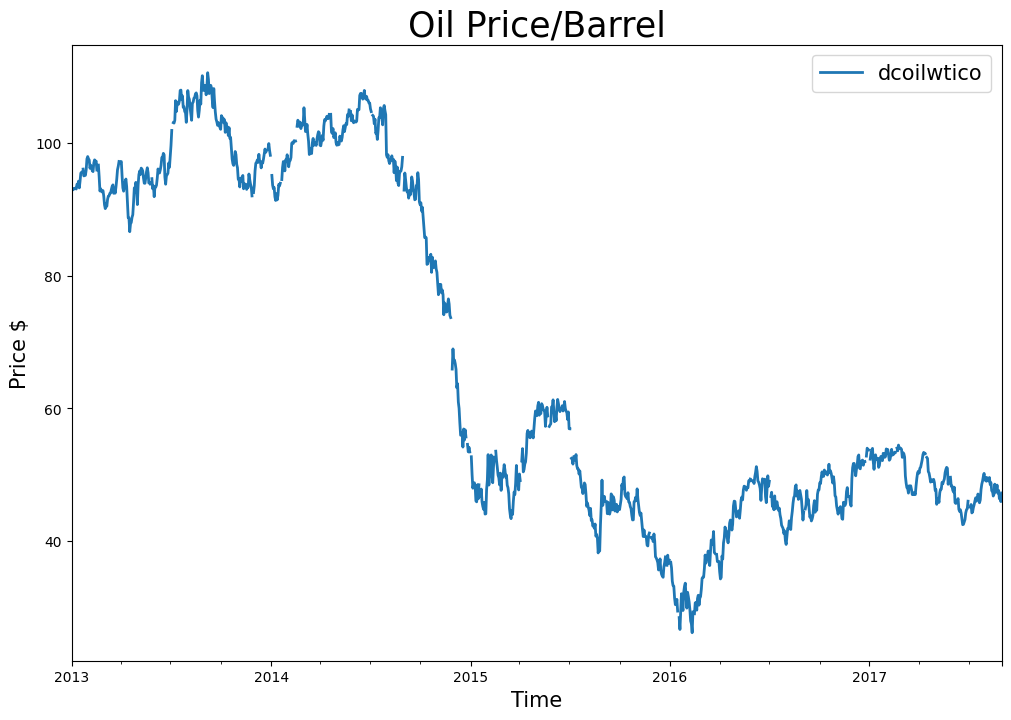

In [24]:
oil=pd.read_csv("../Dataset/oil.csv", parse_dates =['date'])

ax = oil.plot(x='date',y='dcoilwtico',title='Oil Price/Barrel',figsize=(12,8),linewidth=2)

ax.title.set_size(25)
plt.legend(fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Price $',fontsize=15)

In [25]:
# we have some missing values in the oil dataset

oil['dcoilwtico'].isna().sum()

43

In [26]:
#percentage of the missing data
(oil.isna().sum()*100)/len(oil)

date          0.000000
dcoilwtico    3.530378
dtype: float64

In [27]:
# Checking for missing dates
# Min and max dates (range of dates)

data_oil_start = oil.date.min()
data_oil_end = oil.date.max()

# Generate a date range from start_date to end_date
date_range = pd.date_range(start=data_oil_start,end=data_oil_end)

# Use the difference between the date_range and the unique dates in the oil data to find missing dates
missing_dates = date_range.difference(oil['date'])

print("Number of missing dates:", len(missing_dates))

Number of missing dates: 486


In [28]:
# Add missing dates in a DataFrame

missing_df = list(missing_dates)
new_dates = pd.DataFrame(missing_df, columns = ['date'])
new_dates.dtypes

date    datetime64[ns]
dtype: object

In [29]:
# Concatenate the two DataFrames
oil_concatenated = pd.concat([oil, new_dates], ignore_index=False)

# Sort the DataFrame by the 'date' column to ensure dates are in order from least to most
oil_concatenated.sort_values(by='date', inplace=True)

# Reset the index
oil_concatenated.reset_index(drop=True, inplace=True)

oil_concatenated.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-05,NaN


In [30]:
# Filling missing values in oil data

oil= oil_concatenated.interpolate(method="linear",limit_direction="both")
oil.head()

,date,dcoilwtico
0,2013-01-01,93.139999
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-05,93.146667


In [31]:
oil['dcoilwtico'].isna().sum()

0

### Transactions Data

In [32]:
transactions=pd.read_csv("../Dataset/transactions.csv", parse_dates =['date'])
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [33]:
# Checking for missing dates
# Min and max dates (range of dates)

data_trans_start = transactions.date.min()
data_trans_end = transactions.date.max()

# Generate a date range from start_date to end_date
date_range = pd.date_range(start=data_trans_start,end=data_trans_end)

# Use the difference between the date_range and the unique dates in the oil data to find missing dates
missing_dates = date_range.difference(transactions['date'])

print("Number of missing dates:", len(missing_dates))

Number of missing dates: 6


In [34]:
# Add missing dates in a DataFrame

missing_df = list(missing_dates)
new_dates = pd.DataFrame(missing_df, columns = ['date'])
new_dates.dtypes

date    datetime64[ns]
dtype: object

In [35]:
# Concatenate the two DataFrames
trans_concatenated = pd.concat([transactions, new_dates], ignore_index=False)

# Sort the DataFrame by the 'date' column to ensure dates are in order from least to most
trans_concatenated.sort_values(by='date', inplace=True)

# Reset the index
trans_concatenated.reset_index(drop=True, inplace=True)

trans_concatenated.head()

,date,store_nbr,transactions
0,2013-01-01,25.0,770.0
1,2013-01-02,30.0,708.0
2,2013-01-02,31.0,1401.0
3,2013-01-02,32.0,776.0
4,2013-01-02,33.0,1163.0


In [36]:
trans_concatenated.isna().sum()

date            0
store_nbr       6
transactions    6
dtype: int64

In [37]:
# Filling missing values in oil data

transactions= trans_concatenated.interpolate(method="linear",limit_direction="both")
transactions.tail()

,date,store_nbr,transactions
83489,2017-08-15,25.0,849.0
83490,2017-08-15,27.0,1543.0
83491,2017-08-15,28.0,1343.0
83492,2017-08-15,14.0,1241.0
83493,2017-08-15,19.0,1158.0


In [38]:
transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

### Preparing Train Data

In [39]:
train.tail()

,store_nbr,family,sales,onpromotion
date,,,,
2017-08-15,25,POULTRY,172.517,0.0
2017-08-15,25,PLAYERS AND ELECTRONICS,3.000,0.0
2017-08-15,25,PET SUPPLIES,3.000,0.0
2017-08-15,26,BOOKS,0.000,0.0
2017-08-15,1,BABY CARE,0.000,0.0


In [40]:
train.reset_index(inplace=True)
train.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,2013-01-01,42,CELEBRATION,0.0,0.0
2,2013-01-01,42,BREAD/BAKERY,0.0,0.0
3,2013-01-01,42,BOOKS,0.0,0.0
4,2013-01-01,42,BEVERAGES,0.0,0.0


#### Merge oil data

In [42]:
minim = train.date.min()
maxim = train.date.max()
print(minim, maxim)
minim_oil= oil.date.min()
maxim_oil = oil.date.max()
print(minim_oil, maxim_oil)

2013-01-01 00:00:00 2017-08-15 00:00:00
2013-01-01 00:00:00 2017-08-31 00:00:00


In [43]:
df_train1 = pd.merge(train, oil, on="date", how="left")
df_train1.tail()

,date,store_nbr,family,sales,onpromotion,dcoilwtico
3008011,2017-08-15,25,POULTRY,172.517,0.0,47.57
3008012,2017-08-15,25,PLAYERS AND ELECTRONICS,3.000,0.0,47.57
3008013,2017-08-15,25,PET SUPPLIES,3.000,0.0,47.57
3008014,2017-08-15,26,BOOKS,0.000,0.0,47.57
3008015,2017-08-15,1,BABY CARE,0.000,0.0,47.57


In [44]:
df_train1.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64

#### Merge Transactions data

In [46]:
# minim = df_train1.date.min()
# maxim = df_train1.date.max()
# print(minim, maxim)
# minim_trans = transactions.date.min()
# maxim_trans = transactions.date.max()
# print(minim_trans, maxim_trans)

2013-01-01 00:00:00 2017-08-15 00:00:00
2013-01-01 00:00:00 2017-08-15 00:00:00


In [48]:
# transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83494 entries, 0 to 83493
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83494 non-null  datetime64[ns]
 1   store_nbr     83494 non-null  float64       
 2   transactions  83494 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.9 MB


In [47]:
# # Merge train and stores datasets
# train = pd.merge(df_train1, transactions, on="date", how="left")
# train.tail()

MemoryError: Unable to allocate 1.11 GiB for an array with shape (1, 148786308) and data type object

In [50]:
df_train1.drop(columns=['store_nbr', 'family'],inplace=True)

In [51]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   sales        float64       
 2   onpromotion  float64       
 3   dcoilwtico   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 91.8 MB


In [52]:
df_train1.isna().sum()

date           0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64

## Downsampling

Resampling to a lower frequency (downsampling) usually involves an aggregation operation — for example, computing monthly sales totals from daily data. It is also known as "aggregation" or "reduction," and is a data transformation technique used to reduce the granularity of data by reducing the number of data points in a dataset. 

It involves converting high-frequency or fine-grained data into lower-frequency or coarser-grained data. The main purpose of downsampling is to make data more manageable, reduce computational and storage requirements, and make it easier to visualize and analyze data over longer time periods. It can also help in cases where the fine-grained data contains a lot of noise, and reducing the data points can reveal underlying trends and patterns.

In [55]:
df_train1.set_index('date', inplace=True)
df_train1.head()

,sales,onpromotion,dcoilwtico
date,,,
2013-01-01,0.0,0.0,93.139999
2013-01-01,0.0,0.0,93.139999
2013-01-01,0.0,0.0,93.139999
2013-01-01,0.0,0.0,93.139999
2013-01-01,0.0,0.0,93.139999


In [56]:
# Resample first into sum of daily sales

train_clean = df_train1.resample('D').sum()
print(train_clean.shape)

(1688, 3)


In [57]:
train_clean.tail()

,sales,onpromotion,dcoilwtico
date,,,
2017-08-11,826373.722022,14179.0,86979.422447
2017-08-12,792630.535079,8312.0,86254.741722
2017-08-13,865639.677471,9283.0,85530.060997
2017-08-14,760922.406081,8043.0,84805.380272
2017-08-15,762661.935939,10605.0,84769.739456


In [58]:
fig = px.line(train_clean, x=train_clean.index, y='sales', title='Sum of Daily Sales')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [59]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1688 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        1688 non-null   float64
 1   onpromotion  1688 non-null   float64
 2   dcoilwtico   1688 non-null   float64
dtypes: float64(3)
memory usage: 52.8 KB


In [76]:
# Save Daily Sales

output_dir = '../Dataset'
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, 'Daily_Sales.csv')
train_clean.to_csv(output_file, index=True, header=True)

In [77]:
# resample data to monthly frequency and compute the sum of sales for each month

Monthly_sales = train_clean.resample('ME').sum()
print(Monthly_sales.shape)

(56, 3)


In [78]:
Monthly_sales.head()

,sales,onpromotion,dcoilwtico
date,,,
2013-01-31,1.032762e+07,0.0,5.231720e+06
2013-02-28,9.658960e+06,0.0,4.761647e+06
2013-03-31,1.142850e+07,0.0,5.150622e+06
2013-04-30,1.099346e+07,0.0,4.907877e+06
2013-05-31,1.159770e+07,0.0,5.231195e+06


In [79]:
# Drop the last row by index
Monthly_sales.drop(Monthly_sales.index[-1], inplace=True)

In [80]:
Monthly_sales.tail()

,sales,onpromotion,dcoilwtico
date,,,
2017-03-31,2.670402e+07,339291.0,2.722023e+06
2017-04-30,2.589531e+07,371042.0,2.729391e+06
2017-05-31,2.691185e+07,414646.0,2.683345e+06
2017-06-30,2.568282e+07,394582.0,2.416356e+06
2017-07-31,2.701148e+07,409128.0,2.568504e+06


In [81]:
fig = px.line(Monthly_sales, x=Monthly_sales.index, y='sales', title='Sum of Monthly Sales')
fig.update_xaxes(rangeslider_visible=True)

fig.show()

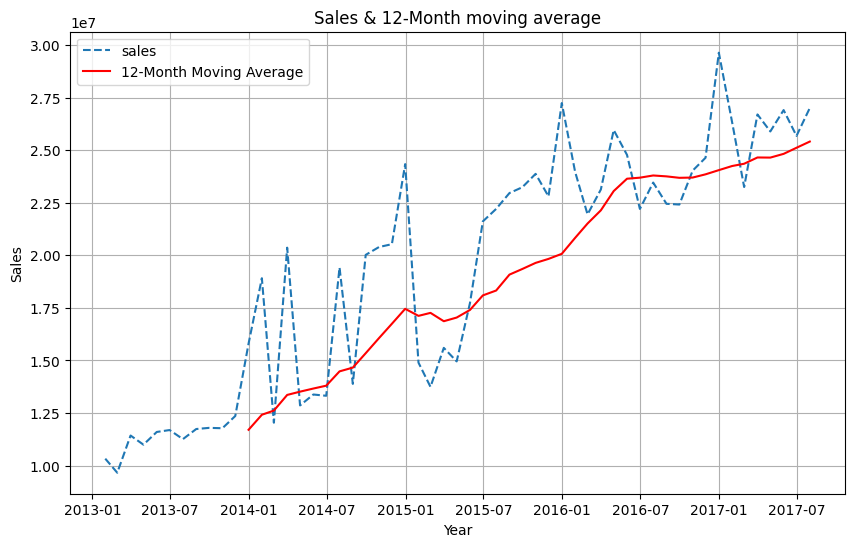

In [82]:
df_MA = Monthly_sales.copy()
MA = df_MA['sales'].rolling(12).mean()

plt.figure(figsize=(10,6))
plt.plot(df_MA.index, df_MA.sales, '--', label='sales')
plt.plot(df_MA.index, MA, label='12-Month Moving Average', color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.title('Sales & 12-Month moving average')
plt.show()

## Stationarity Test

A time series has to have some statistical properties [to be able to stationary](https://python.plainenglish.io/time-series-analysis-mastering-the-concepts-of-stationarity-c9fc489893cf):

- **Constant mean**: There is no trend over time.
- **Constant variance, covariance**: The scale of the data doesn’t change and the relationship between observations is consistent.
- **No seasonality**: Statistical properties of seasonal data changes regularly. Therefore, there is a pattern of change in the mean.

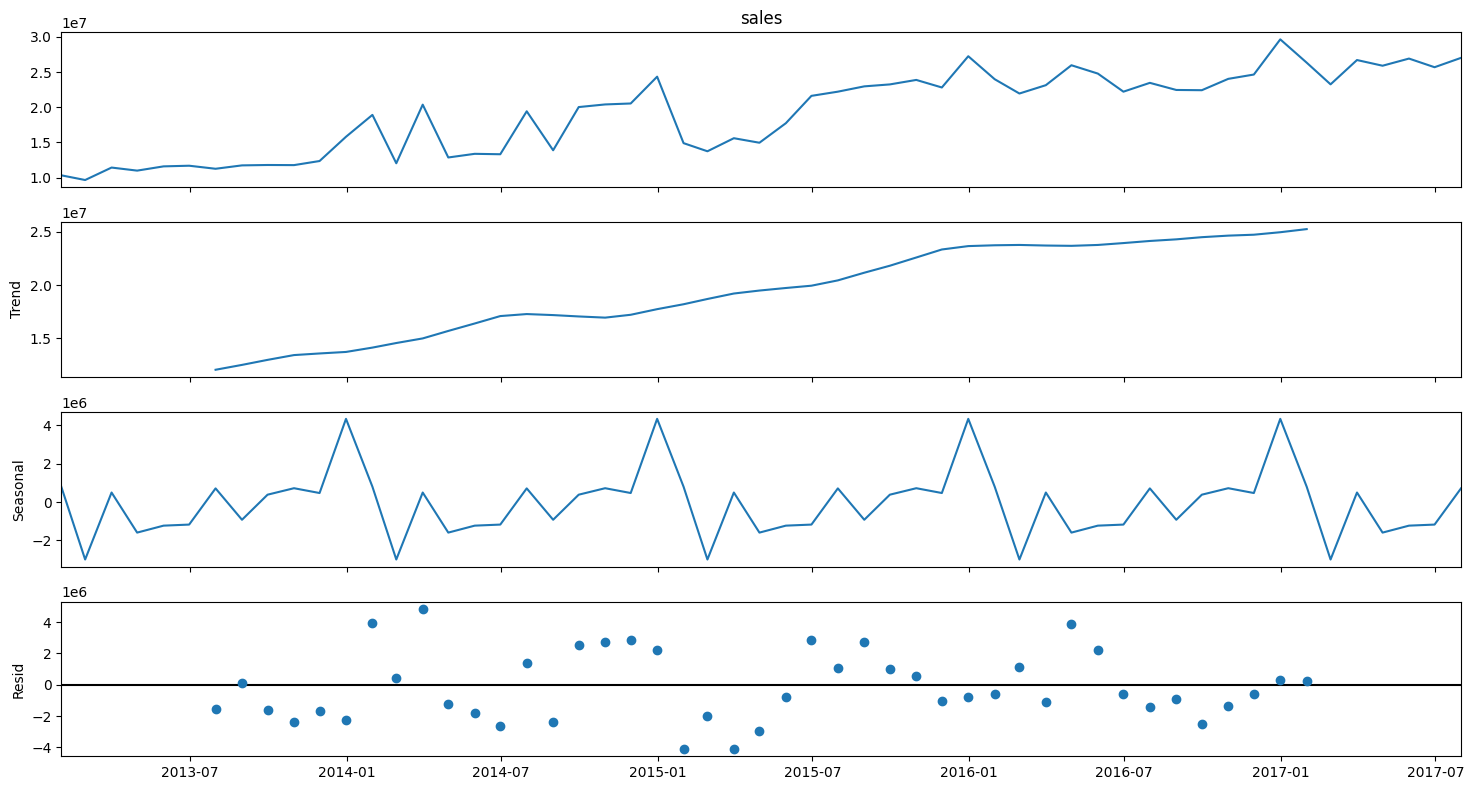

In [83]:
rcParams['figure.figsize'] = 15,8
decompose_series = sm.tsa.seasonal_decompose(Monthly_sales['sales'], model='additive')
decompose_series.plot()
plt.show()

- Increasing trend and seasonality variations

In [85]:
# Ho (Null Hypothesis): The time series data is non-stationary
# H1 (alternate Hypothesis): The time series data is stationary

def check_stationarity(time_series):
    """
    Perform the Augmented Dickey-Fuller test to check for stationarity.

    Parameters:
    time_series (pd.Series): The time series data to test.

    Returns:
    None
    """
    adf_result = adfuller(time_series)
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print(f'No. of lags used: {adf_result[2]}')
    print(f'No. of observations used: {adf_result[3]}')
    print('Critical Values:')
    for k, v in adf_result[4].items():
        print(f'{k}: {v}')
    if adf_result[1] < 0.05:
        print('Series is stationary')
    else:
        print('Series is non-stationary')

In [86]:
check_stationarity(Monthly_sales['sales'])

ADF Statistic: -1.5561885728668226
p-value: 0.5055554852721771
No. of lags used: 1
No. of observations used: 53
Critical Values:
1%: -3.560242358792829
5%: -2.9178502070837
10%: -2.5967964150943397
Series is non-stationary


- We fail to reject the null hypothesis that the series has a unit root (is non-stationary)

### Differencing

- Differencing is a technique used to remove trends or seasonality from a time series data. It involves subtracting the previous value from the current value to detect and remove patterns that vary over time.

In [87]:
#Convert time series to stationary by removing trend and seasonality

Monthly_sales_only = Monthly_sales.drop(columns=['onpromotion', 'dcoilwtico'])
df_log = np.log(Monthly_sales_only)
Monthly_sales_diff = df_log.diff(periods= 1)

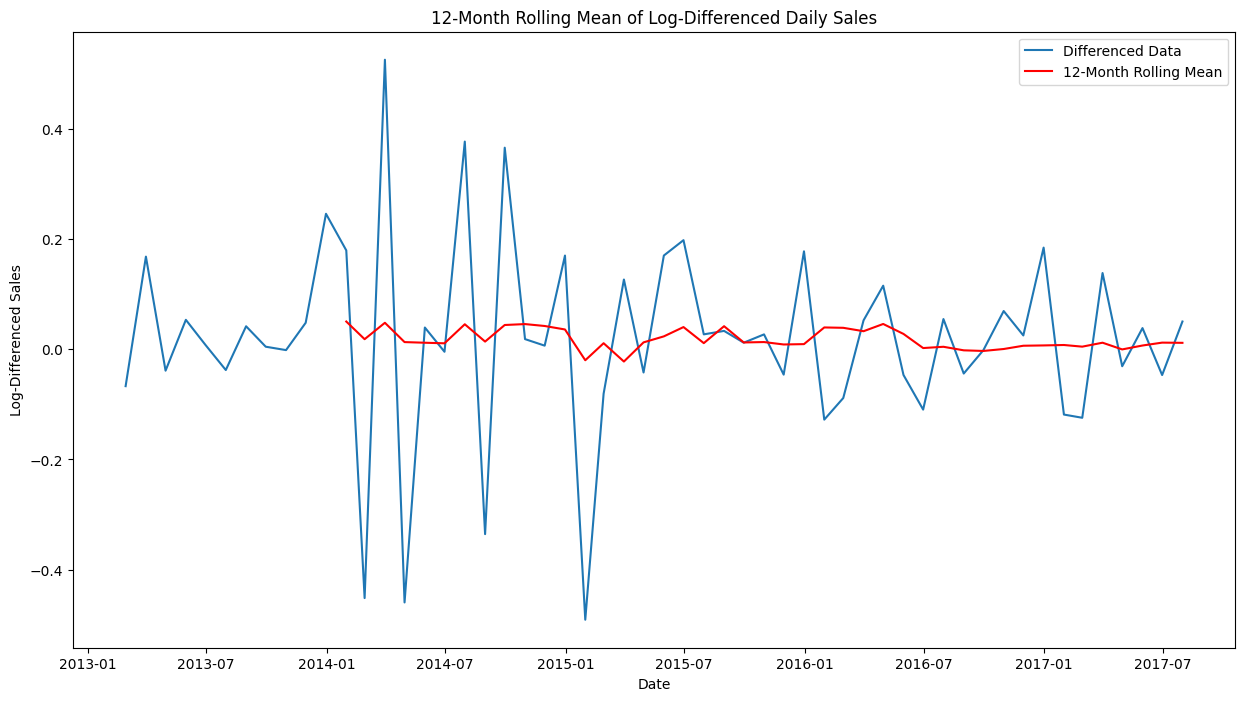

In [88]:
plt.plot(Monthly_sales_diff.index, Monthly_sales_diff['sales'], '-')
plt.plot(Monthly_sales_diff.rolling(12).mean(), color='red')
plt.xlabel('Date')
plt.ylabel('Log-Differenced Sales')
plt.title('12-Month Rolling Mean of Log-Differenced Daily Sales')
plt.legend(['Differenced Data', '12-Month Rolling Mean'])
plt.show()

In [91]:
Monthly_sales_diff = Monthly_sales_diff.dropna()

In [92]:
check_stationarity(Monthly_sales_diff['sales'])

ADF Statistic: -4.452442443765502
p-value: 0.00023943459515555826
No. of lags used: 7
No. of observations used: 46
Critical Values:
1%: -3.5812576580093696
5%: -2.9267849124681518
10%: -2.6015409829867675
Series is stationary


### Autocorrelation Function (ACF):

Autocorrelation refers to the correlation between the past values in a time series. It measures the linear relationship between lagged values in the series. The ACF plot or correlogram is used to display the autocorrelation in a time series by lag. The correlation coefficient between -1 and 1 is displayed on the y-axis and the lags displayed on the x-axis. 

### Partial Autocorrelation Function (PACF):

PACF gives the partial correlation of a stationary series with its lagged values not accounted for by prior lagged observations. This gives an overview of the relationship between an observation in a series and observations in previous time steps while removing interfering observations. The PACF at a specific lag is the correlation that occurs after removing the effect of any correlations as a result of shorter lags. In contrast to ACF, it controls for other lags. 

The ACF and PACF plots are displayed as bar charts showing confidence intervals at 95% and 99% as horizontal lines across the bars. Any bar that crosses these intervals are deemed to be more significant and worth noting.

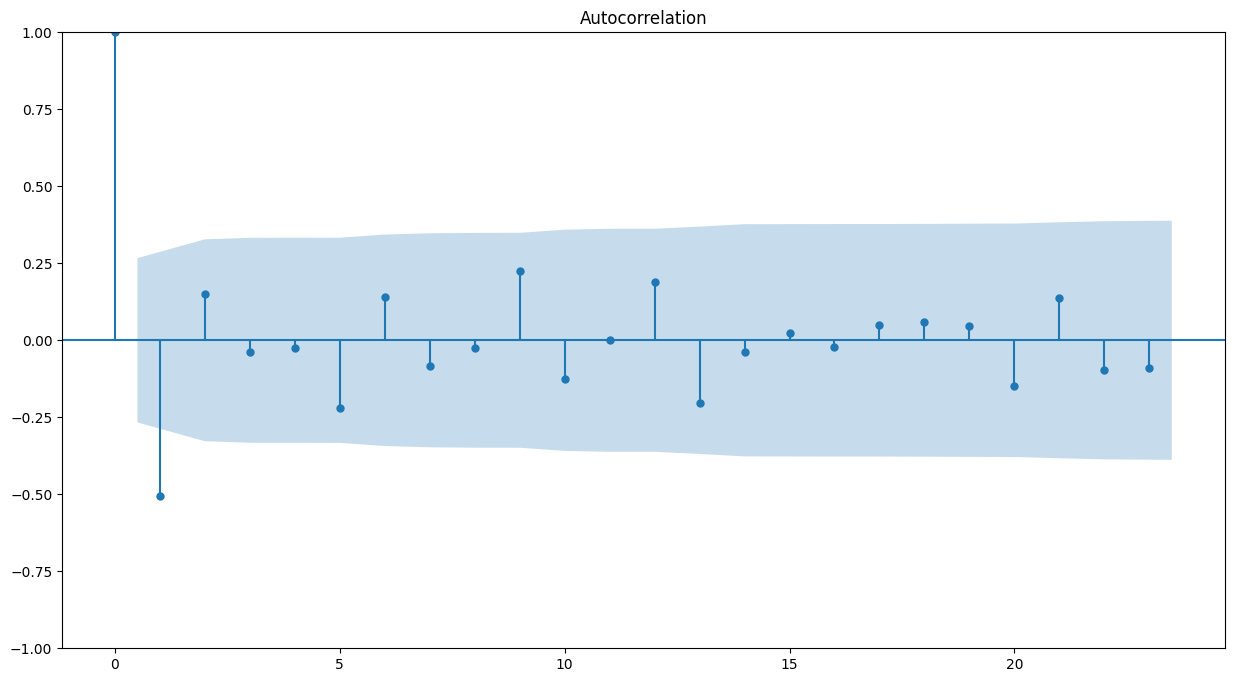

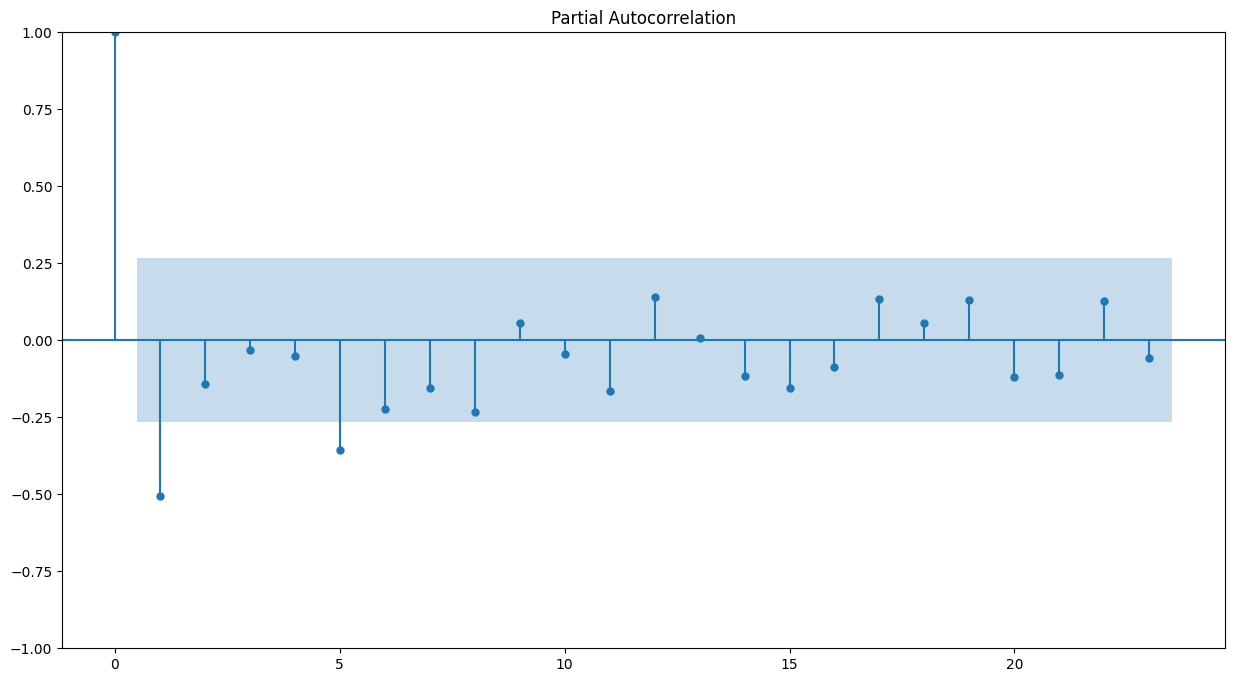

In [93]:
acf = plot_acf(Monthly_sales_diff['sales'].dropna(), lags = 23)
pacf = plot_pacf(Monthly_sales_diff['sales'].dropna(), lags = 23)

In [94]:
# Specify the date to split the data
split_date = '2017-01-01'

# Create train and test splits based on the index order
training_set = Monthly_sales.loc[Monthly_sales.index < split_date]
eval_set = Monthly_sales.loc[Monthly_sales.index >= split_date]

training_set.shape, eval_set.shape


((48, 3), (7, 3))

In [105]:
training_set.head()

,sales,onpromotion,dcoilwtico
date,,,
2013-01-31,1.032762e+07,0.0,5.231720e+06
2013-02-28,9.658960e+06,0.0,4.761647e+06
2013-03-31,1.142850e+07,0.0,5.150622e+06
2013-04-30,1.099346e+07,0.0,4.907877e+06
2013-05-31,1.159770e+07,0.0,5.231195e+06


## Modeling

### ARIMA

In [95]:
# We use pmdarima to determine the best parameter for our ARIMA model.

stepwise_fit = auto_arima(training_set['sales'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1543.705, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1548.474, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1540.005, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1540.950, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1547.204, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1541.731, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1541.768, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1543.759, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1540.034, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.666 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -767.002
Date:                Sat, 13 Jul 2024   AIC                           1540.005
Time:                        01:16:55   BIC                           1545.555
Sample:                    01-31-2013   HQIC                          1542.094
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.832e+05   4.32e+05      1.349      0.177   -2.64e+05    1.43e+06
ar.L1         -0.4152      0.087     -4.764      0.000      -0.586      -0.244
sigma2      8.701e+12      0.033   2.64e+14      0.000     8.7e+12     8.7e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 2.34
Prob(Q):                              0.50   Prob(JB):                         0.31
Heteroskedasticity (H):               0.62   Skew:                            -0.52
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.64e+29. Standard errors may be unstable.
"""

In [96]:
model_1 = ARIMA(training_set['sales'], order=(1,1,0))
model_1_fit = model_1.fit()
model_1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   48
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -768.017
Date:                Sat, 13 Jul 2024   AIC                           1540.034
Time:                        01:17:08   BIC                           1543.734
Sample:                    01-31-2013   HQIC                          1541.426
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3914      0.093     -4.219      0.000      -0.573      -0.210
sigma2      9.038e+12   1.23e-15   7.32e+27      0.000    9.04e+12    9.04e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.41   Prob(JB):                         0.30
Heteroskedasticity (H):               0.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.93e+43. Standard errors may be unstable.
"""

In [97]:
# Make predictions on the test data

ARIMA_pred = model_1_fit.predict(start=len(training_set['sales']),
                                 end=len(training_set['sales']) + len(eval_set['sales']) - 1,
                                 )

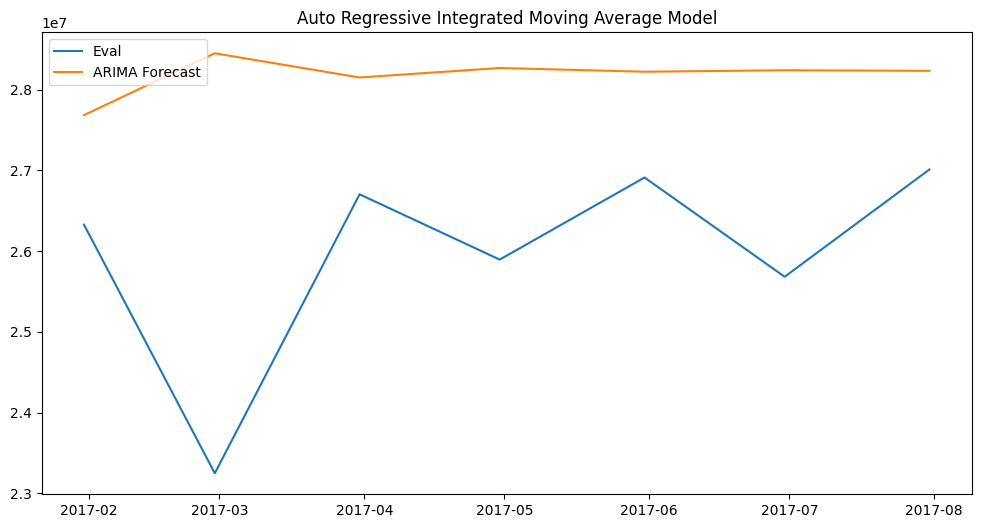

In [98]:
# plot the evaluation and model predictions

plt.figure(figsize = (12,6))
plt.plot(eval_set['sales'], label = 'Eval')
plt.plot (ARIMA_pred, label = 'ARIMA Forecast')
plt.legend(loc='upper left')
plt.title('Auto Regressive Integrated Moving Average Model')
plt.show()

In [100]:
from sklearn.metrics import mean_absolute_percentage_error

mse = mean_squared_error(eval_set['sales'], ARIMA_pred)
rmse = np.sqrt(mean_squared_error(eval_set['sales'], ARIMA_pred)).round(2)
mae = mean_absolute_error(eval_set['sales'], ARIMA_pred).round(2)
mape = mean_absolute_percentage_error(eval_set['sales'], ARIMA_pred).round(2)

# Create results DataFrame
results_1 = pd.DataFrame([['ARIMA', mse, rmse, mae, mape]], columns=['Model', 'MSE', 'RMSE', 'MAE', 'MAPE'])

results_1

,Model,MSE,RMSE,MAE,MAPE
0,ARIMA,6.619920e+12,2572920.46,2208870.42,0.09


### SARIMA

In [101]:
model_2 = SARIMAX(training_set['sales'], order=(1,1,0), seasonal_order=(1,1,0,12))
model_2_fit = model_2.fit()
model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -581.995
Date:                            Sat, 13 Jul 2024   AIC                           1169.991
Time:                                    01:18:38   BIC                           1174.657
Sample:                                01-31-2013   HQIC                          1171.601
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4222      0.181     -2.332      0.020      -0.777      -0.067
ar.S.L12      -0.3342      0.152     -2.194      0.028      -0.633      -0.036
sigma2      1.588e+13   5.59e-15   2.84e+27      0.000    1.59e+13    1.59e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                14.93
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                            -1.12
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.77e+42. Standard errors may be unstable.
"""

In [102]:
SARIMA_pred = model_2_fit.predict(start=len(training_set['sales']),
                                 end=len(training_set['sales']) + len(eval_set['sales']) - 1)

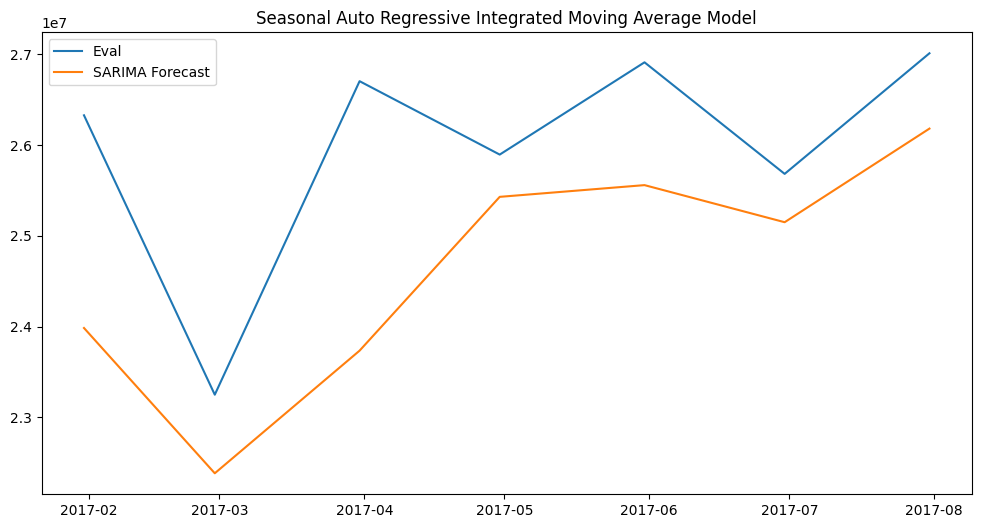

In [103]:
plt.figure(figsize = (12,6))
plt.plot(eval_set['sales'], label = 'Eval')
plt.plot (SARIMA_pred, label = 'SARIMA Forecast')
plt.legend(loc='upper left')
plt.title('Seasonal Auto Regressive Integrated Moving Average Model')
plt.show()

In [104]:
# Calculate the evaluation metrics
mse = mean_squared_error(eval_set['sales'], SARIMA_pred)
rmse = np.sqrt(mean_squared_error(eval_set['sales'], SARIMA_pred)).round(2)
mae = mean_absolute_error(eval_set['sales'], SARIMA_pred).round(2)
mape = mean_absolute_percentage_error(eval_set['sales'], SARIMA_pred).round(2)

# Create a DataFrame to store the results
model_results = pd.DataFrame([['SARIMA', mse, rmse, mae, mape]], columns = ['Model', 'MSE', 'RMSE', 'MAE', 'MAPE'])

# Concatenate with previous results
results_2 = pd.concat([results_1, model_results], ignore_index=True)

# Display the results
results_2

,Model,MSE,RMSE,MAE,MAPE
0,ARIMA,6.619920e+12,2572920.46,2208870.42,0.09
1,SARIMA,2.581896e+12,1606827.93,1336949.31,0.05


### SARIMAX

In [109]:
exog_variables = training_set[['onpromotion', 'dcoilwtico']]
exog_variables_eval = eval_set[['onpromotion', 'dcoilwtico']]

# Define and fit the SARIMAX model with multiple exogenous variables
model_3 = SARIMAX(training_set['sales'], order=(1,1,0), seasonal_order=(1,1,0,12), exog=exog_variables)
model_3_fit = model_3.fit()
model_3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -574.161
Date:                            Sat, 13 Jul 2024   AIC                           1158.322
Time:                                    01:23:23   BIC                           1166.099
Sample:                                01-31-2013   HQIC                          1161.007
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
onpromotion    20.4135     17.040      1.198      0.231     -12.985      53.812
dcoilwtico      2.6490      0.928      2.854      0.004       0.830       4.468
ar.L1          -0.5331      0.192     -2.772      0.006      -0.910      -0.156
ar.S.L12       -0.5516      0.284     -1.945      0.052      -1.108       0.004
sigma2       1.357e+13   1.11e-11   1.22e+24      0.000    1.36e+13    1.36e+13
===================================================================================
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):                 2.53
Prob(Q):                              0.30   Prob(JB):                         0.28
Heteroskedasticity (H):               0.71   Skew:                             0.37
Prob(H) (two-sided):                  0.56   Kurtosis:                         1.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.48e+41. Standard errors may be unstable.
"""

In [110]:
SARIMAX_pred = model_3_fit.predict(start=len(training_set['sales']),
                                   end=len(training_set['sales']) + len(eval_set['sales']) - 1,
                                   exog=exog_variables_eval)

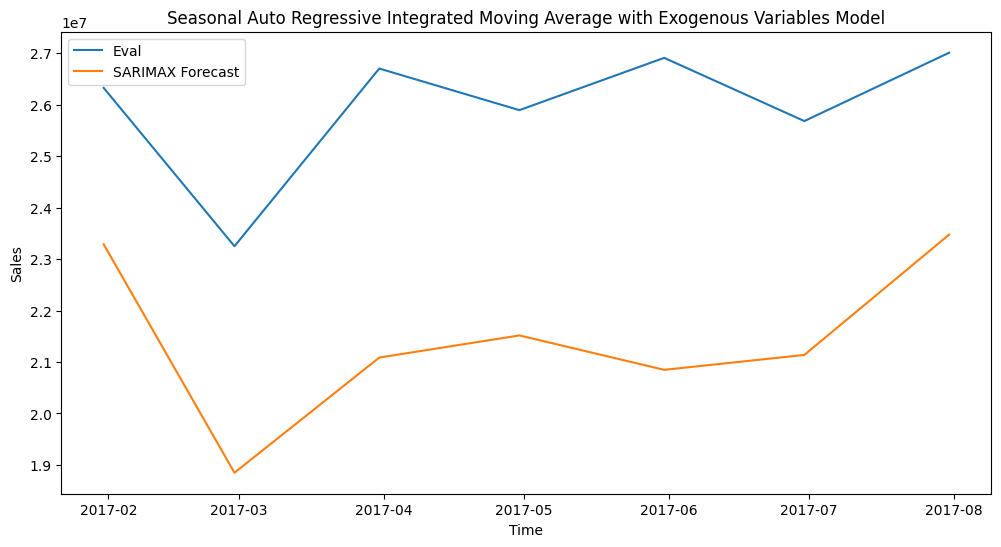

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(eval_set['sales'], label='Eval')
plt.plot(SARIMAX_pred, label='SARIMAX Forecast')
plt.legend(loc='upper left')
plt.title('Seasonal Auto Regressive Integrated Moving Average with Exogenous Variables Model')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

In [112]:
# Calculate the evaluation metrics
mse = mean_squared_error(eval_set['sales'], SARIMAX_pred)
rmse = np.sqrt(mean_squared_error(eval_set['sales'], SARIMAX_pred)).round(2)
mae = mean_absolute_error(eval_set['sales'], SARIMAX_pred).round(2)
mape = mean_absolute_percentage_error(eval_set['sales'], SARIMAX_pred).round(2)

# Create a DataFrame to store the results
model_results = pd.DataFrame([['SARIMAX', mse, rmse, mae, mape]], columns = ['Model', 'MSE', 'RMSE', 'MAE', 'MAPE'])

# Concatenate with previous results
results_3 = pd.concat([results_2, model_results], ignore_index=True)

# Display the results
results_3

,Model,MSE,RMSE,MAE,MAPE
0,ARIMA,6.619920e+12,2572920.46,2208870.42,0.09
1,SARIMA,2.581896e+12,1606827.93,1336949.31,0.05
2,SARIMAX,2.132930e+13,4618365.52,4512217.75,0.17


In [195]:
from pandas.tseries.offsets import DateOffset

future_dates = [Monthly_sales.index[-1] + DateOffset(months=x)for x in range (0,17)]
future_dates_df = pd.DataFrame(index=future_dates[1:], columns=Monthly_sales.columns)
future_dates_df

,sales,onpromotion
2017-08-31,NaN,NaN
2017-09-30,NaN,NaN
2017-10-31,NaN,NaN
2017-11-30,NaN,NaN
2017-12-31,NaN,NaN
2018-01-31,NaN,NaN
2018-02-28,NaN,NaN
2018-03-31,NaN,NaN
2018-04-30,NaN,NaN
2018-05-31,NaN,NaN


In [196]:
SARIMA_pred_2 = model_3_fit.predict(start=len(future_dates['sales']),
                                 end=len(future_dates['sales']))

TypeError: list indices must be integers or slices, not str

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(eval_set['sales'], label = 'Eval')
plt.plot (SARIMA_pred_2, label = 'SARIMA Forecast')
plt.legend(loc='upper left')
plt.title('Seasonal Auto Regressive Integrated Moving Average Model')
plt.show()

In [ ]:
# Predictions

# future_dates = pd.DataFrame(pd.date_range(start='2017-08-16', end='2017-08-31', freq='D'), columns=['dates'])
# future_dates.set_index('dates', inplace=True)
# future_dates.head()

##model_2_fit.predict(start=future_dates.index[0], end=future_dates.index[-1])